## How to fit a line to data

Line fitting is ubiquitous in the natural and physical sciences.

However in the cases we are often taught to learn line-fitting techniques, the data are not realistic. In a field like astronomy, which is based on remote-sensing, the most typical case for our data has both $x$ and $y$ coordinates with uncertainties, as well as truncation due to instrumental limits. In fact, the uncertanties themselves are often poorly known (i.e., there is error on the error).

The likelihood like a probability (density), with which we use to predict observed data conditioned on the parameters of the model that generates them. 

Given a simple linear model, such as: $$y = \beta + \alpha*x,$$ a linear regression analysis takes the parameters (a, b) as input to the linear model to generate an expected y value. This expectation is then compared to the real data, given some additional prior information about those parameters, and produces a probability of this model fitting the data.

import some libraries that we will need:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats # Needed stats.linregress
import statsmodels.api as sm # sm.OLS
import bces  #https://github.com/rsnemmen/BCES

/usr/local/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Create an true underlying dataset

In [46]:
np.random.seed(20)
#intercept = 25 and slope = 0.5
theta_true = (25, 0.15)
xtrue = np.random.normal(40,10,size=100) #Choose a Gaussian distribution in x
ytrue = theta_true[0] + theta_true[1] * xtrue 

Plot the data

(0, 50)

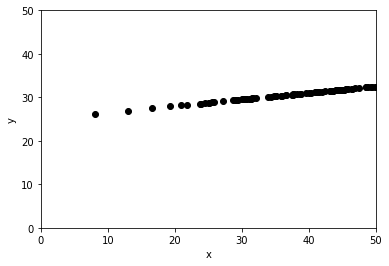

In [47]:
plt.plot(xtrue, ytrue, 'ok')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(0,50)
plt.ylim(0,50)

Now, create the other observable, where the y values are scattered due to a single measurement error (i.e., there is no hidden parameter which would cause one measurement to be an inherently noisier estimate than any other).

This also means that all of the data points would have the same "error bar", which is a Gaussian of width y_std.

You can think of this as experimental statistical error. We will address systematic errors later.

### Add noise to y

In [48]:
#Option 1 is a variable error defined on its own. With some maximum
y_std = 0
while (y_std < 7):
    y_std = 10*np.random.random(1)
#Option 2 is a fixed error depending on a Gaussian around the mean of the data:
y_std = 3
ydata = np.random.normal(ytrue,y_std)
ydata_err = np.zeros(len(ytrue)) + y_std
#We ignore error in x for now
xdata = xtrue
xtrue1= xtrue
xdata_err =  np.zeros(len(xtrue)) 
# Redefine some names of the data
xdata1_err = xdata_err
ydata1_err = ydata_err
xdata1 = xdata
ydata1 = ydata
#Add some outliers
#s = np.random.standard_t(0.5,size=len(ydata))
#ydata = ydata + s

Now, let's mess with this data even more. For instance, most of Astronomy has flux-limited data (i.e., out instruments can only observe data down to some noise limit). So let's apply a cut to the data (on these x and y-values).

### Truncate the y data

In [49]:
limit = np.where((ydata > 31) & (ydata < 100))[0]
keep =  np.random.randint(0, len(xtrue),size=len(limit))

Here is our noisy data followed by the noise truncated data where the red line is the truth:

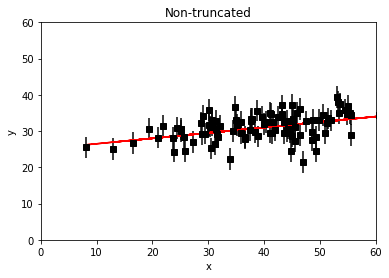

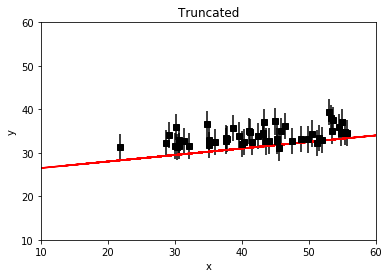

In [52]:
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(0,60)
plt.ylim(0,60)
y_hat = theta_true[0] + theta_true[1]*xdata1
plt.plot(xdata1,y_hat,color='r')
plt.errorbar(xdata1, ydata1,yerr=ydata1_err,color='k',marker='s',linestyle='None')
plt.title('Non-truncated')
plt.show()
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(10,60)
plt.ylim(10,60)
y_hat = theta_true[0] + theta_true[1]*xdata1
plt.title('Truncated')
plt.plot(xdata,y_hat,color='r')
plt.errorbar(xdata1[limit], ydata1[limit],yerr=ydata1_err[limit],color='k',marker='s',linestyle='None')
plt.show()

#### We now use a simple linear (least squares) regression model to fit the data

In [53]:
slope, intercept, r_value, p_value_slope0, std_err = stats.linregress(xdata1,ydata1)
print 'No flux limit: ', slope, intercept, std_err,p_value_slope0
y_fit = intercept + slope*(xdata1)

slope, intercept, r_value, p_value_slope0, std_err = stats.linregress(xdata1[limit],ydata1[limit])
print 'With flux limit: ', slope, intercept,std_err,p_value_slope0
y_fit_wlim = intercept + slope*(xdata1[limit])

slope, intercept, r_value, p_value_slope0, std_err = stats.linregress(xtrue,ytrue)
print 'No flux limit: ', slope, intercept, std_err,p_value_slope0
y_fit = intercept + slope*(xtrue)

No flux limit:  0.14955745144221394 25.361396530848843 0.03004338894977888 2.7518036290968464e-06
With flux limit:  0.09604262330005855 29.8002513439087 0.025538251573631817 0.0004310088537881688
No flux limit:  0.15 25.000000000000004 0.0 0.0


#### Now let's develop a Bayesian model and implement using PYMC

In [54]:
import pymc # for pymc
from pymc import AdaptiveMetropolis  

The full model is in the next block. It contains priors and the likelihood.

In [55]:
# Define the variables needed for the routine, with their prior distributions
alpha1 = pymc.Uniform('alpha1', -40, 40)

# The prior on beta comes from this: https://arxiv.org/pdf/1411.5018.pdf  See also: http://quantumholism.com/wp-content/papercite-data/pdf/robotham2015.pdf
@pymc.stochastic(observed=False)
def beta1(value=0):
    return -1.5 * np.log(1 + value ** 2)


# Define the form of the model and likelihood
@pymc.deterministic
def y_model1(x=xdata1, alpha1=alpha1, beta1=beta1):
    fit = alpha1 + beta1*x
    return fit

# Define the likelihood (as Normal)
y1 = pymc.Normal('y1', mu=y_model1, tau=1/ydata1**2.0, observed=True, value=ydata1)
# package the full model in a dictionary.
#We're going to call this model1
model1 = dict(alpha1=alpha1, beta1=beta1,y_model1=y_model1, y1=y1)

We first declare a PYMC object for the model, we define how we want to stwp along, and we sample (and burn and thin)

In [56]:
S1 = pymc.MCMC(model1)
# Using AdapativeMetropolis, since alpha and beta are correlated
S1.use_step_method(AdaptiveMetropolis,S1.alpha1)
S1.use_step_method(AdaptiveMetropolis,S1.beta1)
S1.sample(iter=200000, burn=10000,thin=10)

 [-----------------100%-----------------] 200000 of 200000 complete in 31.7 sec

The output from this sampling is a matrix, whose components contain values of alpha and beta that were sampled (i.e., traced) in the MCMC run. We can draw histograms or precentiles of those values to see what worked. The more often a value worked, the more densly the posterior is sampled near the value (and thus the more likely the value is).

In [57]:
pymc_trace1 = [S1.trace('alpha1')[:],
               S1.trace('beta1')[:]]
alpha1_median =  np.median(S1.trace('alpha1')[:])
alpha1_05 = np.percentile(S1.trace('alpha1')[:], 5)
alpha1_33 = np.percentile(S1.trace('alpha1')[:], 33)
alpha1_67 = np.percentile(S1.trace('alpha1')[:], 67)
alpha1_95 = np.percentile(S1.trace('alpha1')[:], 95)
beta1_median =  np.median(S1.trace('beta1')[:])
beta1_05 = np.percentile(S1.trace('beta1')[:], 5)
beta1_33 = np.percentile(S1.trace('beta1')[:], 33)
beta1_67 = np.percentile(S1.trace('beta1')[:], 67)
beta1_95 = np.percentile(S1.trace('beta1')[:], 95)
fitter1 = pymc.MAP(model1)
fitter1.fit(iterlim=1000)
alpha1_map = np.float(fitter1.alpha1.value)
beta1_map = np.float(fitter1.beta1.value)
print 'alpha and beta values at maximum: {0:5.3f}'.format(alpha1_map), ',{0:5.3f}'.format(beta1_map)
print "alpha values around median (2 sig): {0:5.3f}".format(alpha1_median), " -{0:5.3f}".format(alpha1_median-alpha1_05), "+{0:5.3f}".format(alpha1_95-alpha1_median)
print "beta values around median (2 sig): {0:5.3f}".format(beta1_median), " -{0:5.3f}".format(beta1_median-beta1_05), "+{0:5.3f}".format(beta1_95-beta1_median)
BIC1 =  fitter1.BIC
print 'BIC= ', BIC1

alpha and beta values at maximum: 30.177 ,-0.008
alpha values around median (2 sig): 24.922  -16.628 +12.506
beta values around median (2 sig): 0.142  -0.323 +0.409
BIC=  881.6729419590345


An intercept of 25 and selope of 0.15 are in there, but the result is noisy.

Now, let's look at the truncated data.

In [58]:
# Define the variables needed for the routine, with their prior distributions
alpha2 = pymc.Uniform('alpha2', -40, 40)

# The prior on beta comes from this: https://arxiv.org/pdf/1411.5018.pdf  See also: http://quantumholism.com/wp-content/papercite-data/pdf/robotham2015.pdf
@pymc.stochastic(observed=False)
def beta2(value=0):
    return -1.5 * np.log(1 + value ** 2)

# Define the form of the model and likelihood
@pymc.deterministic
def y_model2(x=xdata1[limit], alpha2=alpha2, beta2=beta2):
    fit = alpha2 + beta2*x
    return fit

# Define the likelihood (as Normal)
y2 = pymc.Normal('y2', mu=y_model2, tau=1/ydata1[limit]**2.0, observed=True, value=ydata1[limit])
# package the full model in a dictionary.
#We're going to call this model1
model2 = dict(alpha2=alpha2, beta2=beta2, y_model2=y_model2, y2=y2)

In [59]:
S2 = pymc.MCMC(model2)
# Using AdapativeMetropolis, since alpha and beta are correlated
S2.use_step_method(AdaptiveMetropolis,S2.alpha2)
S2.use_step_method(AdaptiveMetropolis,S2.beta2)
S2.sample(iter=200000, burn=10000,thin=10)

 [-----------------100%-----------------] 200000 of 200000 complete in 35.5 sec

In [60]:
pymc_trace2 = [S2.trace('alpha2')[:],
               S2.trace('beta2')[:]]
alpha2_median =  np.median(S2.trace('alpha2')[:])
alpha2_05 = np.percentile(S2.trace('alpha2')[:], 5)
alpha2_33 = np.percentile(S2.trace('alpha2')[:], 33)
alpha2_67 = np.percentile(S2.trace('alpha2')[:], 67)
alpha2_95 = np.percentile(S2.trace('alpha2')[:], 95)
beta2_median =  np.median(S2.trace('beta2')[:])
beta2_05 = np.percentile(S2.trace('beta2')[:], 5)
beta2_33 = np.percentile(S2.trace('beta2')[:], 33)
beta2_67 = np.percentile(S2.trace('beta2')[:], 67)
beta2_95 = np.percentile(S2.trace('beta2')[:], 95)
fitter2 = pymc.MAP(model2)
fitter2.fit(iterlim=1000)
alpha2_map = np.float(fitter2.alpha2.value)
beta2_map = np.float(fitter2.beta2.value)
print 'alpha and beta values at maximum: {0:5.3f}'.format(alpha2_map), ',{0:5.3f}'.format(beta2_map)
print "alpha values around median (2 sig): {0:5.3f}".format(alpha2_median), " -{0:5.3f}".format(alpha2_median-alpha2_05), "+{0:5.3f}".format(alpha2_95-alpha2_median)
print "beta values around median (2 sig): {0:5.3f}".format(beta2_median), " -{0:5.3f}".format(beta2_median-beta2_05), "+{0:5.3f}".format(beta2_95-beta2_median)
BIC2 =  fitter2.BIC
print 'BIC= ', BIC2

alpha and beta values at maximum: 33.481 ,0.071
alpha values around median (2 sig): 24.159  -25.343 +14.153
beta values around median (2 sig): 0.220  -0.364 +0.564
BIC=  488.1994401474265


As with the linear regression, not great.

Finally, let's add a truncation to the model itself:

In [61]:
# Define the variables needed for the routine, with their prior distributions
alpha3 = pymc.Uniform('alpha3', -10,40)

# The prior on beta comes from this: https://arxiv.org/pdf/1411.5018.pdf  See also: http://quantumholism.com/wp-content/papercite-data/pdf/robotham2015.pdf
@pymc.stochastic(observed=False)
def beta3(value=0):
    return -1.5 * np.log(1 + value ** 2)

# Define the form of the model and likelihood
@pymc.deterministic
def y_model3(x=xdata1[limit], alpha3=alpha3, beta3=beta3):
    fit = alpha3 + beta3*x
    return fit

# Define the likelihood (as Normal)
y3 = pymc.TruncatedNormal('y3', y_model3, 1.0/ydata1_err[limit]**2.0, 20.,50.,observed=True, value=ydata1[limit])
# package the full model in a dictionary.
#We're going to call this model1
model3 = dict(alpha3=alpha3, beta3=beta3, y_model3=y_model3, y3=y3)


In [62]:
S3 = pymc.MCMC(model3)
# Using AdapativeMetropolis, since alpha and beta are correlated
S3.use_step_method(AdaptiveMetropolis,S3.alpha3)
S3.use_step_method(AdaptiveMetropolis,S3.beta3)
S3.sample(iter=200000, burn=10000,thin=10)

 [-----------------100%-----------------] 200000 of 200000 complete in 77.7 sec

In [63]:
pymc_trace3 = [S3.trace('alpha3')[:],
               S3.trace('beta3')[:]]
alpha3_median =  np.median(S3.trace('alpha3')[:])
alpha3_05 = np.percentile(S3.trace('alpha3')[:], 5)
alpha3_33 = np.percentile(S3.trace('alpha3')[:], 33)
alpha3_67 = np.percentile(S3.trace('alpha3')[:], 67)
alpha3_95 = np.percentile(S3.trace('alpha3')[:], 95)
beta3_median =  np.median(S3.trace('beta3')[:])
beta3_05 = np.percentile(S3.trace('beta3')[:], 5)
beta3_33 = np.percentile(S3.trace('beta3')[:], 33)
beta3_67 = np.percentile(S3.trace('beta3')[:], 67)
beta3_95 = np.percentile(S3.trace('beta3')[:], 95)
fitter3 = pymc.MAP(model3)
fitter3.fit(iterlim=1000)
alpha3_map = np.float(fitter3.alpha3.value)
beta3_map = np.float(fitter3.beta3.value)
print 'alpha and beta values at maximum: {0:5.3f}'.format(alpha3_map), ',{0:5.3f}'.format(beta3_map)
print "alpha values around median (2 sig): {0:5.3f}".format(alpha3_median), " -{0:5.3f}".format(alpha3_median-alpha3_05), "+{0:5.3f}".format(alpha3_95-alpha3_median)
print "beta values around median (2 sig): {0:5.3f}".format(beta3_median), " -{0:5.3f}".format(beta3_median-beta3_05), "+{0:5.3f}".format(beta3_95-beta3_median)
BIC3 =  fitter3.BIC
print 'BIC= ', BIC3

alpha and beta values at maximum: 30.267 ,0.085
alpha values around median (2 sig): 29.953  -3.321 +3.254
beta values around median (2 sig): 0.092  -0.074 +0.075
BIC=  242.84650599474554


Get's things mostly correct, and better constrained than the non-truncated fit.

Now, let's compare visually.

In [64]:
# Create some convenience routines for plotting
# Taken from: http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/
#The output of the MCMC algorithm is a trace, the sequence of retained samples for each variable in the model. These traces can be accessed using the trace(name, chain=-1) method. 
def compute_sigma_level(trace1, trace2, nbins=20):
    """From a set of traces, bin by number of standard deviations"""
    L, xbins, ybins = np.histogram2d(trace1, trace2, nbins)
    L[L == 0] = 1E-16
    logL = np.log(L)

    shape = L.shape
    L = L.ravel()

    # obtain the indices to sort and unsort the flattened array
    i_sort = np.argsort(L)[::-1]
    i_unsort = np.argsort(i_sort)

    L_cumsum = L[i_sort].cumsum()
    L_cumsum /= L_cumsum[-1]
    
    xbins = 0.5 * (xbins[1:] + xbins[:-1])
    ybins = 0.5 * (ybins[1:] + ybins[:-1])

    return xbins, ybins, L_cumsum[i_unsort].reshape(shape)

def plot_MCMC_results(xdata, ydata, trace,alpha,beta, colors='r'):
    """Plot both the trace and the model together"""
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    plot_MCMC_trace(ax[0], xdata, ydata, trace, True, colors=colors)
    plot_MCMC_model(ax[1], xdata, ydata, trace,alpha,beta)

def plot_MCMC_results2(xdata, ydata, trace,alpha,beta, colors='r'):
    """Plot both the trace and the model together"""
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    plot_MCMC_trace(ax[0], xdata, ydata, trace, True, colors=colors)
    plot_MCMC_model2(ax[1], xdata, ydata, trace,alpha,beta)
    
def plot_MCMC_trace(ax, xdata, ydata, trace, scatter=False, **kwargs):
    """Plot traces and contours"""
    xbins, ybins, sigma = compute_sigma_level(trace[0], trace[1])
    if scatter:
        ax.plot(trace[0], trace[1], ',k', alpha=0.002)
    ax.contour(xbins, ybins, sigma.T,levels=[0.683, 0.955],zorder=3, **kwargs)
    ax.set_xlabel('alpha')
    ax.set_ylabel('beta')
    ax.plot([theta_true[0],theta_true[0]], [theta_true[1],theta_true[1]], 'x',color='green', ms=10)
    
    
def plot_MCMC_model(ax, xdata, ydata, trace,alpha, beta):
    """Plot the linear model and 2sigma contours"""
    ax.plot(xdata, ydata, 'ok')
    mcmc_alpha, mcmc_beta = trace[:2]
    xfit = np.linspace(-20, 120, 10)
    yfit = mcmc_alpha[:, None] + mcmc_beta[:, None] * xfit
    sig = 2 * yfit.std(0)
    mu = alpha + beta * xfit
    ax.plot(xfit, mu, '-k')
    ax.fill_between(xfit, mu - sig, mu + sig, color='lightgray')

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xlim(10,90)
    ax.set_ylim(10,90)
    y_hat = theta_true[0] + theta_true[1]*xtrue
    ax.plot(xtrue,y_hat, linestyle='dotted', color='r' )
    
def plot_MCMC_model2(ax, xdata, ydata, trace,alpha,beta):
    """Plot the linear model and 2sigma contours"""
    ax.plot(xdata, ydata, 'ok')
    mcmc_alpha, mcmc_beta = trace[:2]
    xfit = np.linspace(-20, 120, 10)
    yfit = mcmc_alpha[:, None] + mcmc_beta[:, None] * xfit
    sig = 2 * yfit.std(0)
    mu = alpha + beta * xfit
    ax.plot(xfit, mu, '-k')
    ax.fill_between(xfit, mu - sig, mu + sig, color='lightgray')

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xlim(-10,100)
    ax.set_ylim(-10,100)
    y_hat = theta_true[0] + theta_true[1]*xtrue
    ax.plot(xtrue,y_hat, linestyle='dotted', color='r' )

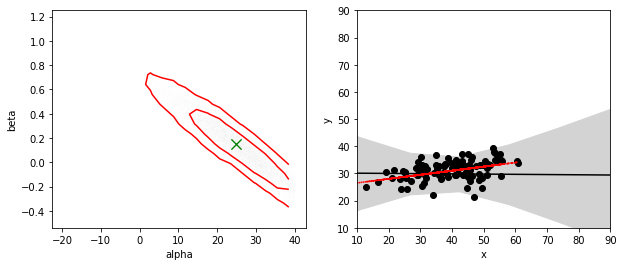

In [65]:
plot_MCMC_results(xdata1, ydata1, pymc_trace1,alpha1_map,beta1_map)
y_fit1 = alpha1_map + xdata1[limit]*beta1_map

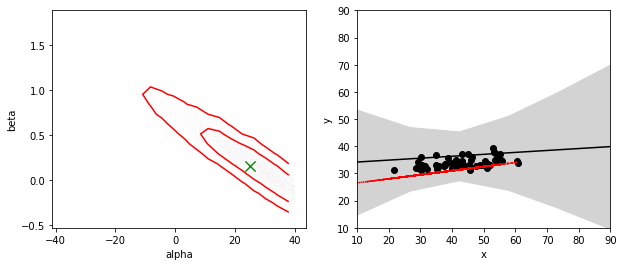

In [66]:
plot_MCMC_results(xdata1[limit], ydata1[limit], pymc_trace2,alpha2_map,beta2_map)
y_fit2 = alpha2_map + xdata1[limit]*beta2_map

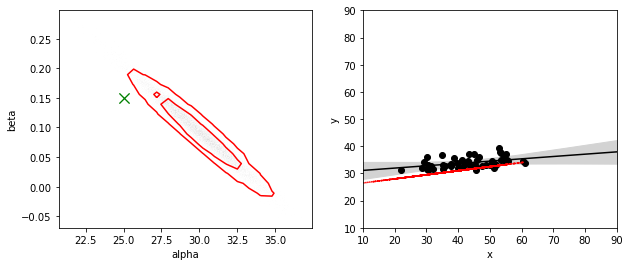

In [67]:
plot_MCMC_results(xdata1[limit], ydata1[limit], pymc_trace3,alpha3_map,beta3_map)
y_fit3 = alpha3_map + xdata1[limit]*beta3_map

Which one you want to publish?